In [ ]:
!pip install kaggle

In [ ]:
!cp /kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': Not a directory


In [ ]:
!kaggle datasets download -d subirbiswas19/skin-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/subirbiswas19/skin-disease-dataset
License(s): CC0-1.0
 93% 16.0M/17.3M [00:01<00:00, 17.4MB/s]
100% 17.3M/17.3M [00:01<00:00, 9.80MB/s]


In [ ]:
!unzip -q skin-disease-dataset.zip -d /content/skin-disease-dataset

Import Libraries and Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Check device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(f"Using device: {device}")


Data Preparation

In [ ]:
# Define transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
#data_dir = '/content/skin-disease-dataset'
#
#image_datasets = {
#    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
#    for x in ['train', 'val']
#}

#/content/skin-disease-dataset/skin-disease-datasaet
# Corrected data directory
data_dir = '/content/skin-disease-dataset/skin-disease-datasaet'

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(root=f"{data_dir}/train_set", transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=f"{data_dir}/test_set", transform=data_transforms['val'])
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")


Classes: ['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot', 'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans', 'VI-chickenpox', 'VI-shingles']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Model Setup

In [42]:
# Load pre-trained ResNet-50
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Output for 8 classes
# Explicitly set device to cuda if available, otherwise cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to the specified device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda


Training and Validation

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 1.1077 Acc: 0.6627
val Loss: 0.3308 Acc: 0.8675
Epoch 2/10
----------
train Loss: 0.4192 Acc: 0.8735
val Loss: 0.2411 Acc: 0.9231
Epoch 3/10
----------
train Loss: 0.3106 Acc: 0.8930
val Loss: 0.2153 Acc: 0.9316
Epoch 4/10
----------
train Loss: 0.2921 Acc: 0.9135
val Loss: 0.1550 Acc: 0.9530
Epoch 5/10
----------
train Loss: 0.2254 Acc: 0.9319
val Loss: 0.0998 Acc: 0.9658
Epoch 6/10
----------
train Loss: 0.2201 Acc: 0.9308
val Loss: 0.1270 Acc: 0.9444
Epoch 7/10
----------
train Loss: 0.2007 Acc: 0.9427
val Loss: 0.1515 Acc: 0.9274
Epoch 8/10
----------
train Loss: 0.2108 Acc: 0.9384
val Loss: 0.1542 Acc: 0.9444
Epoch 9/10
----------
train Loss: 0.1617 Acc: 0.9503
val Loss: 0.1243 Acc: 0.9573
Epoch 10/10
----------
train Loss: 0.1494 Acc: 0.9589
val Loss: 0.1216 Acc: 0.9658
Best val Acc: 0.9658


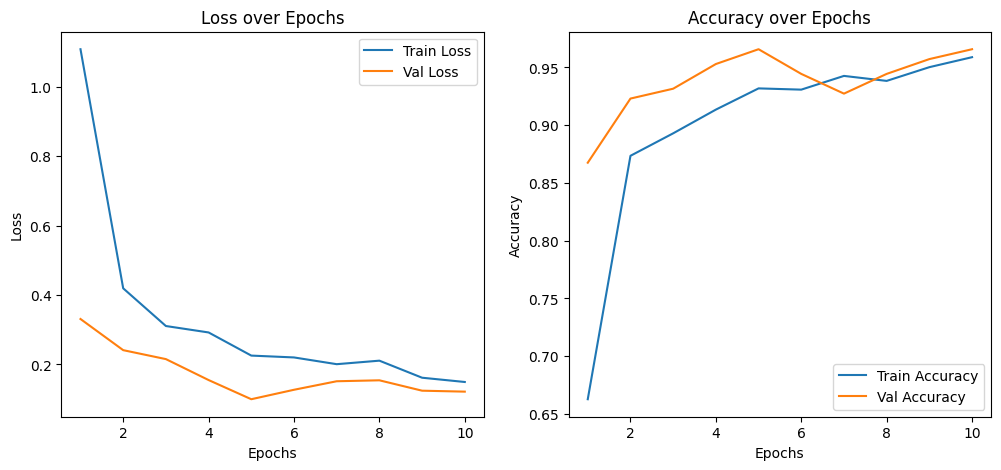

In [43]:
import matplotlib.pyplot as plt

# Training function
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.cpu().item()) # Convert to CPU and get the value
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.cpu().item()) # Convert to CPU and get the value

            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    return model

model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=10)


Evaluation

Confusion Matrix:
[[31  0  1  0  0  0  0  2]
 [ 0 20  0  0  0  0  0  0]
 [ 2  0 30  0  0  0  0  0]
 [ 0  0  1 32  0  0  0  0]
 [ 1  0  0  0 21  0  0  1]
 [ 0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 34  0]
 [ 0  0  0  0  0  0  0 33]]

Classification Report:
                            precision    recall  f1-score   support

            BA- cellulitis       0.91      0.91      0.91        34
               BA-impetigo       1.00      1.00      1.00        20
           FU-athlete-foot       0.94      0.94      0.94        32
            FU-nail-fungus       1.00      0.97      0.98        33
               FU-ringworm       1.00      0.91      0.95        23
PA-cutaneous-larva-migrans       1.00      1.00      1.00        25
             VI-chickenpox       1.00      1.00      1.00        34
               VI-shingles       0.92      1.00      0.96        33

                  accuracy                           0.97       234
                 macro avg       0.97      0.97      0.97  

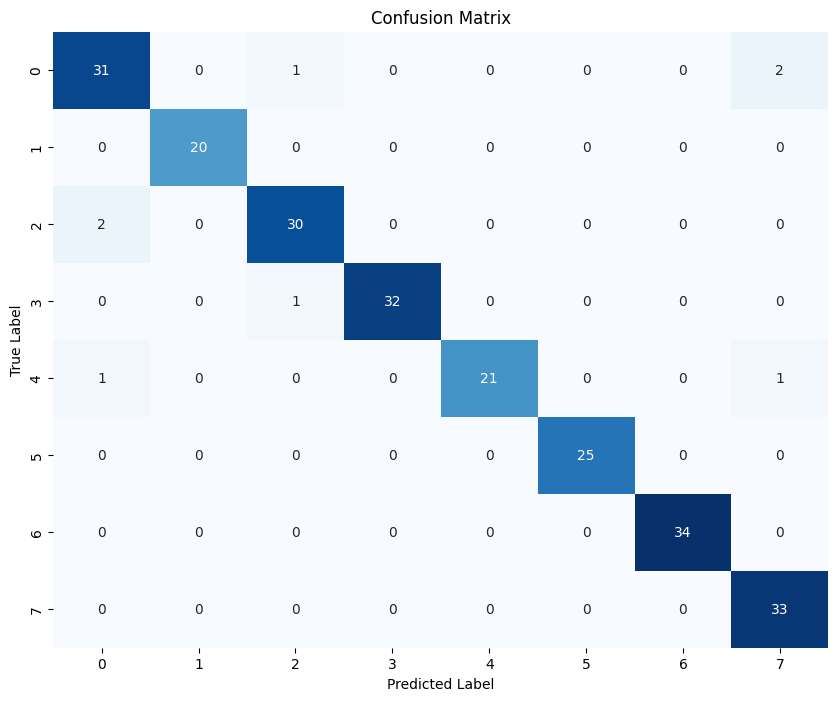

In [44]:
import seaborn as sns
# Test the model on validation set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds) # Calculate the confusion matrix
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Pass the calculated confusion matrix 'cm' to sns.heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[0, 1, 2, 3, 4, 5, 6, 7],
                yticklabels=[0, 1, 2, 3, 4, 5, 6, 7])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(model, dataloaders['val'])

Save model

In [45]:
torch.save(model.state_dict(), "resnet5_skin_dise0ase.pth")